<div dir="rtl">
<font size="4">
تمامی پکیج های زیر به صورت پیش فرض در محیط کولب نصب هستند. اگر روی سیستم خودتان اجرا می گیرید هر پکیجی که نصب نبود ان را نصب نمایید. در چند سلول پایین پکیج های اولیه و داده های اموزش و تست بارگذاری شده اند
</font>
</div>

In [44]:
import numpy as np
import pandas as pd
import nltk
import random
import tqdm
import re
from nltk.corpus import brown
from nltk import word_tokenize
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.decomposition import TruncatedSVD
from nltk.probability import FreqDist
import itertools
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount("/content/drive")
%cd
%cd /content/drive/MyDrive/Project_NLP/data/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/root
/content/drive/MyDrive/Project_NLP/data
tweet_test_data.csv  tweet_train_data.csv


In [6]:
train_df = pd.read_csv('tweet_train_data.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('tweet_test_data.csv', index_col='Unnamed: 0')

In [7]:
print(train_df.info())
print()
print(test_df.info())
print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
 4   target    3263 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 153.0+ KB
None



In [8]:
#train data
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
#test data
test_df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0


<div dir="rtl">
<font size="4">
در سلول زیر نگاهی به وضعیت توزیع ستون target از داده داریم که نشان می دهد اکثر توییت های موجود در پایگاه داده واقعی هستند.
</font>
</div>

In [13]:
target = train_df['target']
np.unique(target)

array([0, 1])

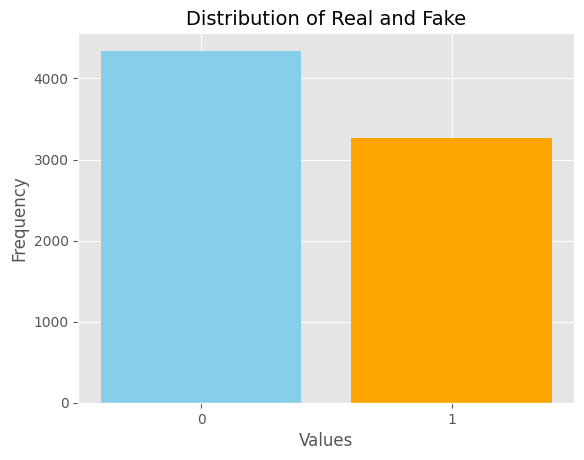

In [22]:
# Use ggplot style for more aesthetic plots
plt.style.use('ggplot')

target = train_df['target']
values, counts = np.unique(target, return_counts=True)

# Create color list. Assign color 'skyblue' for 0 and 'orange' for 1
colors = ['skyblue' if value == 0 else 'orange' for value in values]

plt.bar(values, counts, tick_label=values, color=colors)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Real and Fake', fontsize=14)
plt.grid(True)  # turn the grid on
plt.show()

<div dir="rtl">
<font size="4">
در سلول زیر نمونه ای از توییت ها را مشاهده می کنید</font>
</div>

In [19]:
for i in range(5):
    print('Tweet Number '+str(i+1)+': '+train_df["text"].to_list()[i])

Tweet Number 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tweet Number 2: Forest fire near La Ronge Sask. Canada
Tweet Number 3: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Tweet Number 4: 13,000 people receive #wildfires evacuation orders in California 
Tweet Number 5: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


<div dir="rtl">
<font size="4">
در سلول زیر مشخص شده است که از 3342 مکان مختلف توییت ها زده شده است.</font>
</div>

In [20]:
print('There is '+ str(len(set(train_df["location"].to_list())))+" different loction")

There is 3342 different loction


<div dir="rtl">
<font size="4">
در سلول زیر 20 مکانی که بیشترین توییت ها از انجا زده شده است را مشاهده می کنیم.</font>
</div>

In [21]:
train_df['location'].value_counts().head(n=20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: location, dtype: int64

<div dir="rtl">
<font size="4">
در بخش زیر به پیش پردازش داده می پردازیم. داده شامل یک ستون به نام text است که متن توییت ها دران است.</font>
</div>

In [23]:
#data with Notnull Location
train_df = train_df[train_df['location'].notnull()]
train_df = train_df[train_df['keyword'].notnull()]

In [24]:
train_df.shape

(5080, 5)

In [26]:
train_df.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [27]:
def normalize_sentence(tokenized_sents, minimum_length=2, stopword_removal=True, stopwords_domain=[], lower_case=False, punctuation_removal=True):
    '''
    normalization function
    '''
    normalized_sents = tokenized_sents

    if stopword_removal:
        # Remove stopwords in English and also the given domain stopwords
        stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
        normalized_sents=[[word for word in sentence if (word.lower() not in stopwords_domain + stopwords)] for sentence in tokenized_sents ]

    if punctuation_removal:
        # Remove punctuations
        normalized_sents=[[word for word in sentence if word not in string.punctuation] for sentence in normalized_sents ]

    if lower_case:
        # Convert everything to lowercase and filter based on a min length
        normalized_sents=[[word.lower() for word in sentence if len(word)>minimum_length] for sentence in normalized_sents ]

    elif minimum_length>1:
        normalized_sents= [[word for word in sentence if len(word)>minimum_length] for sentence in normalized_sents ]

    return normalized_sents

In [28]:
new_df = list(train_df['text'])
for i in range(len(new_df)):
  new_df[i] = new_df[i].split()
len(new_df)

5080

In [32]:
new_df = normalize_sentence(new_df)

<div dir="rtl">
<font size="4">
در بخش زیر کلمات کلیدی مربوط به همه توییت هارا استخراج می کنیم</font>
</div>

In [ ]:
mp_freqdist = FreqDist(itertools.chain(*new_df))        # compute the frequency distribution
top20words=mp_freqdist.most_common(20)      # show the top 20 (word, frequency) pairs
print ('%-16s' % 'word', '%-16s' % 'Frequency','%-16s' %  '% of the total')
for topword in top20words:
    percent=(topword[1]/len(new_df))*100
    print ('%-16s' % topword[0], '%-16s' % topword[1],'%-16s' %  percent)

word             Frequency        % of the total  
like             210              4.133858267716536
&amp;            193              3.7992125984251968
I'm              159              3.12992125984252
via              150              2.952755905511811
get              121              2.3818897637795278
fire             101              1.988188976377953
people           97               1.909448818897638
one              93               1.830708661417323
new              87               1.7125984251968505
...              80               1.574803149606299
would            75               1.4763779527559056
know             72               1.4173228346456692
New              72               1.4173228346456692
see              64               1.2598425196850394
going            63               1.2401574803149606
got              61               1.2007874015748032
still            61               1.2007874015748032
burning          61               1.2007874015748032
bui

In [34]:
for i in range(train_df.shape[0]):
  train_df['text'].iloc[i] = ' '.join(new_df[i])

<ipython-input-34-0faf2b0ce767>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'].iloc[i] = ' '.join(new_df[i])


In [35]:
train_df.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,always try bring heavy. #metal #RT http://t.co...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying more! Set ablaze,0
35,53,ablaze,"London, UK",plus side LOOK SKY LAST NIGHT ABLAZE http://t....,0


<div dir="rtl">
<font size="4">
در بخش زیر با استفاده از Tfidf یک ماتریس از داده ورودی می سازیم</font>
</div>

In [37]:
Tfidf_vect = TfidfVectorizer()
Train_content_tfidf = Tfidf_vect.fit_transform(train_df['text'].astype(str))
print(Train_content_tfidf.shape)

(5080, 16260)


<div dir="rtl">
<font size="4">
در بخش زیر با استفاده از svd کاهش ابعادی روی ماتریس به دست امده در مرحله قبل اعمال می کنیم</font>
</div>

In [38]:
svd_ = TruncatedSVD(n_components=2000, n_iter=7, random_state=42).fit(Train_content_tfidf)
svd = svd_.transform(Train_content_tfidf)

In [40]:
svd.shape, Train_content_tfidf.shape

((5080, 2000), (5080, 16260))

In [42]:
target = train_df['target'].to_list()

In [43]:
SKF = StratifiedKFold(n_splits=5, shuffle=True)

<div dir="rtl">
<font size="4">
در بخش زیر نیز کلاس بندی را با استفاده از ماتریس اولیه ( نه ماتریس کاهش ابعاد داده شده ) انجام می دهیم تا دقت کاهش ابعاد را بررسی کنیم
</font>
</div>

In [45]:
for model in [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),SVC(), AdaBoostClassifier(), XGBClassifier()]:
  model_name = str(model).split('(',1)[0]
  print(f' Accuracy of {model_name}  : {round(cross_val_score(model,Train_content_tfidf,target,cv=SKF,scoring="accuracy").mean()*100,2)}%')

 Accuracy of LogisticRegression  : 77.8%
 Accuracy of DecisionTreeClassifier  : 70.73%
 Accuracy of RandomForestClassifier  : 76.65%
 Accuracy of KNeighborsClassifier  : 76.24%
 Accuracy of SVC  : 78.29%
 Accuracy of AdaBoostClassifier  : 72.87%
 Accuracy of XGBClassifier  : 76.97%


<div dir="rtl">
<font size="4">
در بخش زیر اجرایی از چند مدل شبکه عصبی روی داده ورودی می گیریم تا دقت کلاس بندی انها را با هم مقایسه کنیم و بهترین مدل برای این داده انتخاب شود</font>
</div>

In [46]:
for model in [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),SVC(), AdaBoostClassifier(), XGBClassifier()]:
  model_name = str(model).split('(',1)[0]
  print(f' Accuracy of {model_name}  : {round(cross_val_score(model,svd,target,cv=SKF,scoring="accuracy").mean()*100,2)}%')

 Accuracy of LogisticRegression  : 78.29%
 Accuracy of DecisionTreeClassifier  : 64.67%
 Accuracy of RandomForestClassifier  : 73.01%
 Accuracy of KNeighborsClassifier  : 75.39%
 Accuracy of SVC  : 78.54%
 Accuracy of AdaBoostClassifier  : 71.56%
 Accuracy of XGBClassifier  : 75.81%


<div dir="rtl">
<font size="4">
حال از نتایج به دست امده استفاده کرده و بهترین مدل را روی داده تست اجرا میکنیم
</font>
</div>

In [47]:
model = SVC()
model.fit(svd, target)
Tfidf_vect = TfidfVectorizer()
Test_Train_content_tfidf = Tfidf_vect.fit_transform(test_df['text'].astype(str))
tes_svd_ = TruncatedSVD(n_components=2000, n_iter=7, random_state=42).fit(Test_Train_content_tfidf)
tes_svd = tes_svd_.transform(Test_Train_content_tfidf)
pred = model.predict(tes_svd)
accuracy_score(pred, test_df['target'])

0.617223414036163